<a href="https://colab.research.google.com/github/ropholuo/ESE546-Intro-to-Deep-learning/blob/main/jinhuil_hw2_problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4 
Jinhui Luo  42838256

In [ ]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi


Ngrok already installed


In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
!./ngrok authtoken 1zKZnwOzbJkGwK18RJSF7uj3G2a_2Fm6tUcpYsY5nAztRJ6gH

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: http://9053-104-198-59-2.ngrok.io


In [ ]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

  

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

logger = Logger('./logs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss, accuracy = [], []
    for epoch in range(epochs):
      correct = 0
      total = 0
      model.train()
      for i, (images, labels) in enumerate(train_loader):
          # Move tensors to configured device
          images = images.to(device)
          labels = labels.to(device)
          #Forward Pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))

      if plot:
        info = { ('training_loss_' + model_name): loss.item() }

        for tag, value in info.items():
          logger.scalar_summary(tag, value, epoch+1)

      train_loss.append(loss.item())
      scheduler.step()

      model.eval()
      with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
      if plot:
        info = { ('testing_accuracy_' + model_name): 100 * correct / total }

        for tag, value in info.items():
          logger.scalar_summary(tag, value, epoch+1)
      print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
      accuracy.append(100 * correct / total)

    # epo = list[range(1, 70)]
    # fig, (ax1, ax2) = plt.subplots(2, 1)
    # ax1.plot(epo, train_loss, 'o-')
    # ax1.set_ylabel('Training loss')

    # ax2.plot(epo, accuracy, 'o-')
    # ax2.set_xlabel('Number of epoch')
    # ax2.set_ylabel('Tesing accuracy')

    # plt.show()




model = allcnn_t().to(device)
#TODO: Set it as number of epochs states in the question
epochs = 70
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=10**(-3))
# TODO: Set milestones for stepping learning rate
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[28,56], gamma=0.1)
# Training loop called here
train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn', True)

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

Files already downloaded and verified
Files already downloaded and verified
Num parameters:  1667166
Epoch [1/70], Step [1000/3125], Loss: 1.4562
Epoch [1/70], Step [2000/3125], Loss: 1.2126
Epoch [1/70], Step [3000/3125], Loss: 1.3224
Accuracy of the network on the test images: 51.83 %
Epoch [2/70], Step [1000/3125], Loss: 0.9412
Epoch [2/70], Step [2000/3125], Loss: 1.3777
Epoch [2/70], Step [3000/3125], Loss: 1.2637
Accuracy of the network on the test images: 62.57 %
Epoch [3/70], Step [1000/3125], Loss: 0.8119
Epoch [3/70], Step [2000/3125], Loss: 0.9870
Epoch [3/70], Step [3000/3125], Loss: 0.9357
Accuracy of the network on the test images: 65.4 %
Epoch [4/70], Step [1000/3125], Loss: 0.8655
Epoch [4/70], Step [2000/3125], Loss: 0.8690
Epoch [4/70], Step [3000/3125], Loss: 1.3571
Accuracy of the network on the test images: 69.16 %
Epoch [5/70], Step [1000/3125], Loss: 1.1996
Epoch [5/70], Step [2000/3125], Loss: 1.4636
Epoch [5/70], Step [3000/3125], Loss: 0.7050
Accuracy of the n

**Save the model in gdrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Colab Notebooks/ESE546/HW2

ls: cannot access '/content/drive/MyDrive/Colab': No such file or directory
ls: cannot access 'Notebooks/ESE546/HW2': No such file or directory


In [ ]:
model_save_name = 'hw2_p4_model.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/ESE546/HW2/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['m.1.0.weight', 'm.1.0.bias', 'm.1.2.weight', 'm.1.2.bias', 'm.1.2.running_mean', 'm.1.2.running_var', 'm.1.2.num_batches_tracked', 'm.2.0.weight', 'm.2.0.bias', 'm.2.2.weight', 'm.2.2.bias', 'm.2.2.running_mean', 'm.2.2.running_var', 'm.2.2.num_batches_tracked', 'm.3.0.weight', 'm.3.0.bias', 'm.3.2.weight', 'm.3.2.bias', 'm.3.2.running_mean', 'm.3.2.running_var', 'm.3.2.num_batches_tracked', 'm.5.0.weight', 'm.5.0.bias', 'm.5.2.weight', 'm.5.2.bias', 'm.5.2.running_mean', 'm.5.2.running_var', 'm.5.2.num_batches_tracked', 'm.6.0.weight', 'm.6.0.bias', 'm.6.2.weight', 'm.6.2.bias', 'm.6.2.running_mean', 'm.6.2.running_var', 'm.6.2.num_batches_tracked', 'm.7.0.weight', 'm.7.0.bias', 'm.7.2.weight', 'm.7.2.bias', 'm.7.2.running_mean', 'm.7.2.running_var', 'm.7.2.num_batches_tracked', 'm.9.0.weight', 'm.9.0.bias', 'm.9.2.weight', 'm.9.2.bias', 'm.9.2.running_mean', 'm.9.2.running_var', 'm.9.2.num_batches_tracked', 'm.10.0.weight', 'm.10.0.bias', 'm.10.2.weight', 'm.10.2.bias', 

**4(b)**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = allcnn_t().to(device)
path = F"/content/drive/MyDrive/Colab Notebooks/ESE546/HW2/hw2_p4_model.pt"
model.load_state_dict(torch.load(path))

Num parameters:  1667166


<All keys matched successfully>

Plot the gradient for images

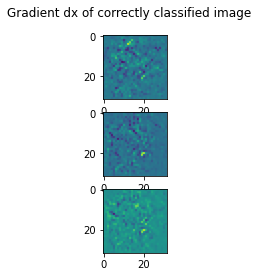

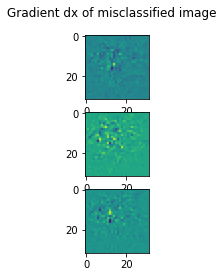

In [ ]:
for i, (x, y) in enumerate(trainloader):
  x = x.to(device)
  y = y.to(device)
  if i==0:
    break

model.train()
x.requires_grad_()
x.retain_grad()
yh = model.forward(x)
x.requires_grad_()
x.retain_grad()
loss = nn.CrossEntropyLoss()
loss = loss.forward(yh, y)
loss.backward()
x_grad = x.grad.data.clone()
_, predicted = torch.max(yh, 1)

pred_correct, pred_incorrect = False, False
for i, pred in enumerate(predicted):
  if pred_correct == True and pred_incorrect == True:
    break

  if pred == y[i] and pred_correct == False:
    pred_correct = True
    img1 = x_grad[i].cpu()
    plt.figure()
    plt.subplot(311)
    plt.imshow(img1[0])
    plt.subplot(312)
    plt.imshow(img1[1])
    plt.subplot(313)
    plt.imshow(img1[2])
    plt.suptitle('Gradient dx of correctly classified image')

  if pred != y[i] and pred_incorrect == False:
    pred_incorrect = True
    img2 = x_grad[i].cpu()
    plt.figure()
    plt.subplot(311)
    plt.imshow(img2[0])
    plt.subplot(312)
    plt.imshow(img2[1])
    plt.subplot(313)
    plt.imshow(img2[2])  
    plt.suptitle('Gradient dx of misclassified image')        

Gradient attack

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader_perturb = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

for i, (xs, ys) in enumerate(trainloader_perturb):
  xs = xs.to(device)
  ys = ys.to(device)
  if i==0:
    break


In [ ]:

eps = 8/255
ell = []
criterion = nn.CrossEntropyLoss()

for x, y in zip(xs, ys):
  x = x.reshape([1,3,32,32])
  y = y.reshape([1])
  step_loss = []

  for i in range(5):
    model.eval()
    x.requires_grad_()
    x.retain_grad()
    outputs = model.forward(x)  
    loss = criterion(outputs, y)
    loss.backward()
    step_loss.append(loss.item())

    dx = x.grad.data.clone()
    sign = torch.sign(dx)
    x.requires_grad = False
    x = torch.add(x, eps * sign)
    x.requires_grad = True

  ell.append(step_loss)

([<matplotlib.axis.XTick at 0x7f673249c550>,
 <a list of 5 Text major ticklabel objects>)

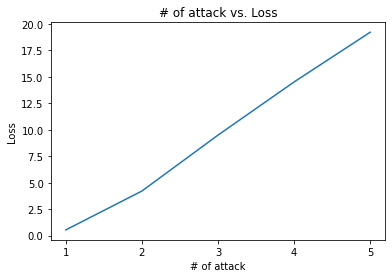

In [ ]:
ell = np.mean(ell, axis=0)
step = np.arange(5) + 1

plt.plot(step, ell)
plt.title('# of attack vs. Loss')
plt.xlabel('# of attack')
plt.ylabel('Loss')
plt.xticks(step)

**(c)**
Compute the validation set accuracy

In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for i, (images, labels) in enumerate(testloader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Accuracy of the network on the test images: 88.79 %


In [ ]:
accuracy = 100 * correct / total

Compute the perturbed validation set accuracy

In [ ]:
eps = 8/255
ell = []
criterion = nn.CrossEntropyLoss()
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader):
  images = images.to(device)
  labels = labels.to(device)

  for x, y in zip(images, labels):
    x = x.reshape([1,3,32,32])
    y = y.reshape([1])

    model.eval()
    x.requires_grad_()
    x.retain_grad()
    outputs = model(x)  
    loss = criterion(outputs, y)
    loss.backward()

    dx = x.grad.data.clone()
    sign = torch.sign(dx)
    x.requires_grad = False
    x = torch.add(x, eps * sign)
    x.requires_grad = True
    outputs = model(x)  

    _, predicted = torch.max(outputs.data, 1)
    total += 1
    if predicted == y:
      correct += 1

print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))



Accuracy of the network on the test images: 28.65 %


The accuracy of perturbed test dataset is 28.65%, comparing with the initial 88.79%, the accuracy greatly decreased.